In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 
import pandas as pd

import pickle
#from pcygni_5 import PcygniCalculator
#from pcygni_profile import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
#import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    #plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [2]:
# Read the kurucz line lists
def read_kurucz(filename):
    '''
     Line files with names GF* or HY* have the following 160 column format:

     1                                                                             80
     +++++++++++^^^^^^^++++++^^^^^^^^^^^^+++++^++++++++++^^^^^^^^^^^^+++++^++++++++++
        800.7110  0.116 27.00   45924.947  3.5 (3F)5s e2F   33439.661  4.5 (3F)4p y2G
         wl(nm)  log gf elem      E(cm-1)   J   label        E'(cm-1)   J'   label'  
                        code                                                         
                             [char*28 level descriptor  ][char*28 level descriptor  ]

     continuing                                                                      
     81                                                                           160
     ^^^^^^++++++^^^^^^++++^^++^^^++++++^^^++++++^^^^^+++++^+^+^+^+++^^^^^+++++^^^^^^
       8.19 -5.38 -7.59K88  0 0 59-2.584 59 0.000  104  -77F6 -5 0    1140 1165     0
       log   log   log ref NLTE iso log iso  log     hyper  F F'    eveglande     iso
      Gamma Gamma Gamma   level hyper f iso frac   shift(mK)     ^    oddglande shift
       rad  stark  vdW    numbers                    E    E'     ^abc  (x1000)   (mA)
                                                              I*1^char*3
                                                                codes

     FORMAT(F11.4,F7.3,F6.2,F12.3,F5.2,1X,A10,F12.3,F5.2,1X,A10,
     3F6.2,A4,2I2,I3,F6.3,I3,F6.3,2I5,1X,A1,A1,1X,A1,A1,i1,A3,2I5,I6) 


      1 wavelength (nm)  air above 200 nm   F11.4
      2 log gf  F7.3
      3 element code = element number + charge/100.  F6.2
      4 first energy level  in cm-1   F12.3
             (if allowed, with same parity as ground state) 
             (negative energies are predicted or extrapolated)
             (sources for observed Es and gLandes are given in B* or C* files)
      5 J for first level   F5.1
        blank for legibility   1X
      6 label field for first level   A10
      7 second energy level  in cm-1   F12.3
             (if allowed, with parity opposite first level) 
      8 J for second level   F5.1
        blank for legibility   1X
      9 label field for second level   A10
     10 log of radiative damping constant, Gamma Rad  F6.2 or F6.3
     11 log of stark damping constant/electron number. Gamma Stark  F6.2 or F6.3
     12 log of van der Waals damping constant/neutral hydrogen number, 
            Gamma van der Waals   F6.2 or F6.3
     13 reference that can be expanded in gfxxyy*.lab   A4  
            Kxx are computed by Kurucz in year xx.  
            fourth character:  blank = E1, M = M1, N = M2, Q = E2, O = E4 
     14 non-LTE level index for first level   I2
     15 non-LTE level index for second level   I2
     16 isotope number   I3
     17 hyperfine component log fractional strength  F6.3
     18 isotope number  (for diatomics there are two and no hyperfine)   I3
     19 log isotopic abundance fraction   F6.3
     20 hyperfine shift for first level in mK to be added to E  I5
     21 hyperfine shift for second level in mK to be added to E'  I5
        the symbol "F" for legibilty   1X
     22 hyperfine F for the first level    I1
     23 note on character of hyperfine data for first level: z none, ? guessed  A1
        the symbol "-" for legibility    1X
     24 hyperfine F' for the second level  I1
     25 note on character of hyperfine data for second level: z none, ? guessed  A1
     26 1-digit code, sometimes for line strength classes   I1
     27 3-character code such as AUT for autoionizing    A3  
     28 lande g for the even level times 1000   I5
     29 lande g for the odd level times 1000   I5
     30 isotope shift of wavelength in mA 
     '''
    widths=[11,7,6,12,5,11,12,5,11,
             6,6,6,4,2,2,3,6,3,
             6,5,5,
             1,1,1,1,1,1,
             1,3,5,5,6]
    colspecs=((0,11),(11,18),(18,24),(24,36),(36,41),(42,52),(52,64),(64,69),(69,80),
               (80,86),(86,92),(92,98),(98,102),(102,104),(104,106),(106,109),(109,115),(115,118),
               (118,124),(124,129),(129,134),
               (135,136),(136,137),(138,139),(139,140),
               (140,141),(141,144),(144,149),(149,154),(154,160))
    dtypes = (np.float64,np.float64,np.float64,np.float64,np.float64,str,np.float64,np.float64,str,
               np.float64,np.float64,np.float64,str,np.int64,np.int64,np.int64,np.float64,np.int64,
               np.float64,np.int64,np.int64,
               str,str,str,str,
               np.int64,str,np.int64,np.int64,np.int64)
    colnames = ('wl','loggf','species','Elo','Jlo','labello','Ehi','Jhi','labelhi', #1-9
                 'rad','stark','vdW','ref','NLTElo','NLTEhi','isotope','hyperstrength','isotope2', #10-18
                 'isoabund','hyperlo','hyperhi', #19-21
                 'hyperFlo','hypernotelo','hyperFhi','hypernotehi', #22-25
                 'strengthclassnote','trans_code','lande_g_even','lande_g_odd','iso_shift') #26-30
    DF = pd.read_fwf(filename,colspecs=colspecs,dtypes=dtypes,names=colnames)
 #     DF = pd.read_fwf(filename,width=widths,dtypes=dtypes,names=colnames)
    return DF
HeI = read_kurucz('gf0200.all.txt')
#YI = read_kurucz('Ytrrium_gfall08oct17')

#YI[YI['wl']<9000]

In [3]:
HeI

,wl,loggf,species,Elo,Jlo,labello,Ehi,Jhi,labelhi,rad,...,hyperhi,hyperFlo,hypernotelo,hyperFhi,hypernotehi,strengthclassnote,trans_code,lande_g_even,lande_g_odd,iso_shift
0,50.4259,-17.078,2.0,0.00,0.0,s2 1S,198310.760,81.0,CONTINUUM,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,50.4303,-5.396,2.0,0.00,0.0,s2 1S,198293.621,1.0,80p 1P,0.0,...,0,NaN,NaN,NaN,NaN,1.0,NaN,0,0,NaN
2,50.4304,-5.380,2.0,0.00,0.0,s2 1S,198293.185,1.0,79p 1P,0.0,...,0,NaN,NaN,NaN,NaN,1.0,NaN,0,0,NaN
3,50.4305,-5.363,2.0,0.00,0.0,s2 1S,198292.731,1.0,78p 1P,0.0,...,0,NaN,NaN,NaN,NaN,1.0,NaN,0,0,NaN
4,50.4306,-5.346,2.0,0.00,0.0,s2 1S,198292.260,1.0,77p 1P,0.0,...,0,NaN,NaN,NaN,NaN,1.0,NaN,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626,7501.5754,-1.445,2.0,195262.49,2.0,6f 3F,196595.180,1.0,8d 3D,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1627,7501.5754,-1.275,2.0,195262.49,3.0,6f 3F,196595.180,2.0,8d 3D,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1628,7501.5754,-3.795,2.0,195262.49,2.0,6f 3F,196595.180,3.0,8d 3D,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1629,7501.5754,-2.165,2.0,195262.49,3.0,6f 3F,196595.180,3.0,8d 3D,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


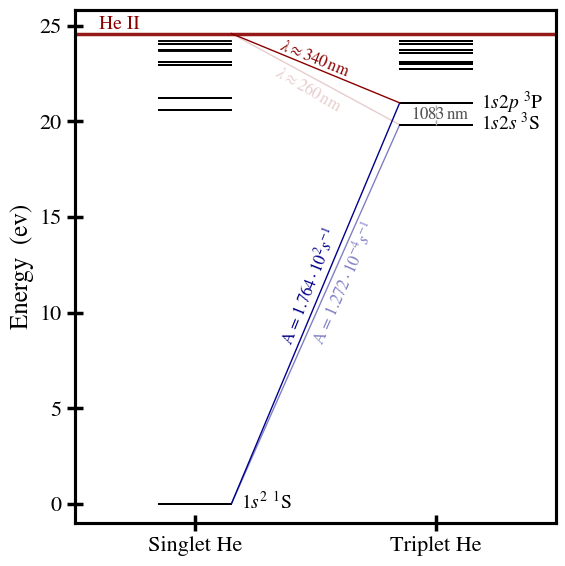

In [221]:
HeI = HeI[(HeI['loggf'] > -2.5)] #& (YI['Ehi'] < 35000) #& (YI['wl'] < 1200) & (YI['wl']>330)]

wl_n = HeI['wl']
Elow = HeI['Elo']
Ehig = HeI['Ehi']
Elow_lab = HeI['labello']
Ehig_lab = HeI['labelhi']
gf = HeI['loggf']

#Y_n
Elow_lab[:]

x_lo = []
x_hi = []

unique_elements, indices = np.unique([i[3:4] for i in HeI['labello']], return_index=True)
# Sort array2 based on the unique elements of array1
sorted_array2 = np.array(Elow)[indices]
sorted_unique_elements = unique_elements[np.argsort(sorted_array2)]

reset_plt(16,18)
fig,ax = plt.subplots(figsize=(6,6))
for i,j,k,m,gf_i,wl_i in zip(Elow,Ehig, Elow_lab, Ehig_lab,gf,wl_n): 
    #if k[:3] == 'd5s': 
    #    x.append(1)
    for idx, label in enumerate(sorted_unique_elements):
        if k[3:4] == label:
            x_lo.append(idx)
            low = idx
    
            dx = 0.15
            plt.plot([-dx+low,dx+low], [i,i], color='k', linewidth=1.1)
    #plt.plot([-dx+high,dx+high], [j,j], color='k')

#plt.plot([-dx,dx], [0,0], color='k')
#plt.plot([-dx+2,dx+2], [25070,25070], color='k')
plt.ticklabel_format(useOffset=False, style='plain')
plt.ylabel('Energy  (ev)')


#ax.set_ylim(-2000,36000)
#ax.set_yticks([0, 10000, 20000, 30000], ['0', '10 000', '20 000', '30 000'])

#ax2 = ax.twinx()
#ax2.set_ylim(-2000,36000)
ax.set_yticks((8065.54429)*np.arange(0,26,5), np.arange(0,26,5))
ax.grid(), 
#ax2.grid()
#ax2.set_ylabel('Energy (eV)', labelpad = 20)

    
ax.yaxis.set_tick_params(which = 'major', direction = 'inout', width = 2.5, length = 12, zorder = 1)
ax2.yaxis.set_tick_params(which = 'major', direction = 'inout', width = 2.5, length = 12, zorder = 1)
ax.xaxis.set_tick_params(which = 'major', direction = 'inout', width = 2.5, length = 12, zorder = 1)

plt.axhline(198310.6691, ls='-', linewidth=2.5, color='darkred', alpha=0.9)
plt.ylim(198310.6691*(-0.04), 198310.6691*1.05)
plt.xlim(-0.5, 1.5)
plt.xticks([0,1],['Singlet He', 'Triplet He'])

plt.text(-0.4, 198310.6691*1.01, r'He II', color='darkred', fontsize=14)
plt.text(1+0.19, 159855.9745*0.985, r'$1s2s$ $^3$S', fontsize=14)
plt.text(1+0.19, 169086*0.985, r'$1s2p$ $^3$P', fontsize=14)
plt.text(0+0.19, -2000, r'1$s^2$ $^1$S', fontsize=14)

plt.text(1-0.105, 159855.9745*1.015, r'1083$\,$nm', fontsize=12, color='darkgrey')
plt.text(1-0.105, 159855.9745*1.015, r'1083$\,$nm', fontsize=12, color='k', alpha=0.5)
plt.text(0.47, 169086/2.5, 'A = $1.272 \cdot 10^{-4} s^{-1}$', rotation=66, fontsize=12, color='darkblue', alpha=0.5 )
plt.text(0.34, 169086/2.5, 'A = $1.764 \cdot 10^{2} s^{-1}$', rotation=68, fontsize=12, color='darkblue' )

plt.text(0.32, 198310/1.20, r'$\lambda \approx 260\,$nm', rotation=-30, fontsize=12, color='darkred', alpha=0.2 )
plt.text(0.34, 198310/1.10 , r'$\lambda \approx 340\,$nm', rotation=-22, fontsize=12, color='darkred' )

plt.plot([0+dx,1-dx],[0, 159855.9745] , alpha=0.5, color='darkblue', linewidth=1)
plt.plot([0+dx,1-dx],[0, 169086]      , alpha=1, color='darkblue', linewidth=1  )

plt.plot([0+dx,1-dx],[198310, 159855]      , alpha=0.2, color='darkred', linewidth=1  )
plt.plot([0+dx,1-dx],[198310, 169086]      , alpha=1, color='darkred', linewidth=1  )

plt.plot([1,1], [159855.9745, 169086], color='darkgrey', linewidth=1, ls='--')


#plt.xlim(-0.9,4.9)
plt.tight_layout()
#plt.savefig('Grotrian_diagram_helium.png', dpi=300)

In [53]:
unique_elements

array(['1', '2', '3'], dtype='<U1')

In [47]:
np.unique(HeI['labello'])

array(['2p 1P', '2p 2P', '2p 3P', '2p 3P av', '2s 1S', '2s 3S', '3d 1D',
       '3d 3D', '3p 1P', '3p 3P', '3s 1S', '3s 3S', '4d 1D', '4d 3D',
       '4f 1F', '4f 3F', '4p 1P', '4p 3P', '4s 1S', '4s 3S', '5d 1D',
       '5d 3D', '5f 1F', '5f 3F', '6d 1D', '6d 3D', '6f 1F', '6f 3F',
       's2 1S'], dtype=object)

In [55]:
np.unique([i[3:5] for i in HeI['labello']])

array(['1D', '1F', '1P', '1S', '2P', '3D', '3F', '3P', '3S'], dtype='<U2')

In [43]:
sorted_unique_elements

array([' 1', ' 3', ' 2'], dtype='<U2')

In [16]:
Elow[indices]

KeyError: '[55, 21, 18, 7, 139, 124, 157, 102, 110, 101, 302, 297, 325, 326, 328, 293, 330, 308, 368, 374, 437, 432, 438, 439, 0] not in index'

In [17]:
indices

array([ 55,  79,  21,  75,  18,   7, 139, 124, 157, 102, 110, 101, 302,
       297, 325, 326, 328, 293, 330, 308, 373, 368, 374, 375, 437, 432,
       438, 439,   0])

In [18]:
Elow

73           0.00
74           0.00
75           0.00
76           0.00
77           0.00
          ...    
1625    195262.49
1626    195262.49
1627    195262.49
1629    195262.49
1630    195262.49
Name: Elo, Length: 444, dtype: float64

In [26]:
unique_elements

array(['2p 1P', '2p 2P', '2p 3P', '2p 3P av', '2s 1S', '2s 3S', '3d 1D',
       '3d 3D', '3p 1P', '3p 3P', '3s 1S', '3s 3S', '4d 1D', '4d 3D',
       '4f 1F', '4f 3F', '4p 1P', '4p 3P', '4s 1S', '4s 3S', '5d 1D',
       '5d 3D', '5f 1F', '5f 3F', '6d 1D', '6d 3D', '6f 1F', '6f 3F',
       's2 1S'], dtype=object)

In [ ]:
1s2	1S	0	     0.000	M02
 	 	 	 	 
1s2s	3S	1	159855.9745	M02
 	 	 	 	 
1s2s	1S	0	166277.4403	M02
 	 	 	 	 
1s2p	3P°	2	169086.7666	M02
 	 	1	169086.8430	M02
 	 	0	169087.8309	M02
 	 	 	 	 
1s2p	1P°	1	171134.8970	M02
 	 	 	 	 
1s3s	3S	1	183236.7918	M02
 	 	 	 	 
1s3s	1S	0	184864.8294	M02
 	 	 	 	 
1s3p	3P°	2	185564.5620	M02
 	 	1	185564.5840	M02
 	 	0	185564.8547	M02
 	 	 	 	 
1s3d	3D	3	186101.5463	M02
 	 	2	186101.5488	M02
 	 	1	186101.5930	M02
 	 	 	 	 
1s3d	1D	2	186104.9668	M02
 	 	 	 	 
1s3p	1P°	1	186209.3651	M02
 	 	 	 	 
1s4p	1P°	1	191492.7120

In [ ]:
para_label=['1s^2', '1s2s',]
ortho_label = 